In [1]:
import torch
import torch.nn as nn
import math
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import numpy as np

In [2]:
pkpd_times_np = np.array([0.0, 1.0, 2.0, 4.0, 8.0, 12.0, 24.0, 36.0, 48.0, 72.0, 168.0, 336.0, 480.0, 481.0, 482.0, 484.0, 488.0, 492.0, 504.0, 552.0, 600.0, 672.0, 840.0, 1008.0, 1176.0])

In [3]:
# -----------------------------
# example PK/PD MODEL DEFINITIONS
# -----------------------------
def one_comp_oral(t, y, ka, CL, V):
    """One-compartment oral absorption model."""
    A_gut, A_c = y
    dA_gut = -ka * A_gut
    dA_c = ka * A_gut - (CL / V) * A_c
    return [dA_gut, dA_c]
def two_comp_iv(t, y, CL, Vc, Vp, Q):
    """Two-compartment IV bolus model (linear elimination)."""
    A_c, A_p = y
    dA_c = -(CL / Vc) * A_c - Q/Vc * A_c + Q/Vp * A_p
    dA_p = Q/Vc * A_c - Q/Vp * A_p
    return [dA_c, dA_p]
def indirect_response(t, y, kin, kout, IC50, C):
    """Indirect response model where drug inhibits production."""
    R = y[0]  # biomarker response
    inhibition = C / (IC50 + C)  # inhibitory Emax model with Emax=1
    dR = kin * (1 - inhibition) - kout * R
    return [dR]
# -----------------------------
# SIMULATION FUNCTIONS
# -----------------------------
def simulate_one_comp(dose, ka, CL, V, times):
    y0 = [dose, 0.0]
    sol = solve_ivp(one_comp_oral, [times[0], times[-1]], y0,
                    t_eval=times, args=(ka, CL, V))
    conc = sol.y[1] / V
    return conc
def simulate_two_comp(dose, CL, Vc, Vp, Q, times):
    y0 = [dose, 0.0]
    sol = solve_ivp(two_comp_iv, [times[0], times[-1]], y0,
                    t_eval=times, args=(CL, Vc, Vp, Q))
    conc = sol.y[0] / Vc
    return conc
def simulate_indirect_one(dose, ka, CL, V, kin, kout, IC50, times):
    # First simulate PK using one-compartment oral model
    A_gut0, A_c0 = dose, 0.0
    pk_sol = solve_ivp(one_comp_oral, [times[0], times[-1]], [A_gut0, A_c0],
                       t_eval=times, args=(ka, CL, V))
    conc = pk_sol.y[1] / V
    # Then feed PK concentrations into indirect response model
    R0 = kin / kout  # baseline
    biomarker = [R0]
    for i in range(1, len(times)):
        tspan = [times[i-1], times[i]]
        sol = solve_ivp(indirect_response, tspan, [biomarker[-1]],
                        t_eval=[times[i]], args=(kin, kout, IC50, conc[i]))
        biomarker.append(sol.y[0, -1])
    return np.array(biomarker)

def simulate_indirect_two(dose, CL, Vc, Vp, Q, kin, kout, IC50, times):
    # First simulate PK using two-compartment model
    y0 = dose, 0.0
    pk_sol = solve_ivp(two_comp_iv, [times[0], times[-1]], y0,
                       t_eval=times, args=(CL, Vc, Vp, Q))
    conc = pk_sol.y[0] / Vc
    # Then feed PK concentrations into indirect response model
    R0 = kin / kout  # baseline
    biomarker = [R0]
    for i in range(1, len(times)):
        tspan = [times[i-1], times[i]]
        sol = solve_ivp(indirect_response, tspan, [biomarker[-1]],
                        t_eval=[times[i]], args=(kin, kout, IC50, conc[i]))
        biomarker.append(sol.y[0, -1])
    return np.array(biomarker)
# -----------------------------
# NOISE & VARIABILITY
# -----------------------------
def add_noise(conc, sigma=0.1, add_err=0.05):
    """
    Add combined proportional + additive error.
    sigma : proportional error (CV%)
    add_err : additive error
    """
    noise = np.random.normal(0, add_err, size=conc.shape)
    return conc + noise
def apply_iiv(param, omega=0.2):
    """Apply inter-individual variability (log-normal)."""
    return param * np.exp(np.random.normal(0, omega))

# values have to be positive
def make_positive(conc):
  if np.min(conc)<0:
    return conc - np.min(conc)
  else:
    return conc
# -----------------------------
# SYNTHETIC DATA GENERATOR
# -----------------------------
def generate_synthetic_dataset(N, model_classes, dose, times=np.array([0.5,1,2,4,6,8,12,24])):
    dataset = []
    for i in range(N):
        # Randomly choose model type
        model_type = np.random.choice(model_classes)

        if model_type == "one_comp":
            # Sample parameters
            ka = apply_iiv(np.random.uniform(0.5, 2.0))
            CL = apply_iiv(np.random.uniform(5.0, 20.0))
            V = apply_iiv(np.random.uniform(20.0, 50.0))
            dose = dose
            conc = simulate_one_comp(dose, ka, CL, V, times)
            conc_noisy = add_noise(conc)
            conc_noisy = make_positive(conc_noisy)
            dataset.append({"id": i, "model": "one_comp", "times": times, "dose" : dose,
                            "concentration": conc_noisy, "params": {"ka": ka, "CL": CL, "V": V}})

        elif model_type == "two_comp":
            CL = apply_iiv(np.random.uniform(5.0, 20.0))
            Vc = apply_iiv(np.random.uniform(10.0, 30.0))
            Vp = apply_iiv(np.random.uniform(20.0, 60.0))
            Q = apply_iiv(np.random.uniform(2.0, 10.0))
            dose = dose
            conc = simulate_two_comp(dose, CL, Vc, Vp, Q, times)
            conc_noisy = add_noise(conc)
            conc_noisy = make_positive(conc_noisy)
            dataset.append({"id": i, "model": "two_comp", "times": times, "dose" : dose,
                            "concentration": conc_noisy, "params": {"CL": CL, "Vc": Vc, "Vp": Vp, "Q": Q}})

        elif model_type == "indirect-one":
            ka = apply_iiv(np.random.uniform(0.5, 2.0))
            CL = apply_iiv(np.random.uniform(5.0, 15.0))
            V = apply_iiv(np.random.uniform(20.0, 40.0))
            kin = apply_iiv(np.random.uniform(0.5, 1.5))
            kout = apply_iiv(np.random.uniform(0.2, 0.8))
            IC50 = np.random.uniform(1.0, 5.0)
            dose = dose
            biomarker = simulate_indirect_one(dose, ka, CL, V, kin, kout, IC50, times)
            biomarker_noisy = add_noise(biomarker)
            biomarker_noisy = make_positive(biomarker_noisy)
            dataset.append({"id": i, "model": "indirect-one", "times": times, "dose" : dose,
                            "response": biomarker_noisy, "params": {"ka": ka, "CL": CL, "V": V,
                                                                     "kin": kin, "kout": kout, "IC50": IC50}})

        elif model_type == "indirect-two":
            CL = apply_iiv(np.random.uniform(5.0, 20.0))
            Vc = apply_iiv(np.random.uniform(10.0, 30.0))
            Vp = apply_iiv(np.random.uniform(20.0, 60.0))
            Q = apply_iiv(np.random.uniform(2.0, 10.0))
            kin = apply_iiv(np.random.uniform(0.5, 1.5))
            kout = apply_iiv(np.random.uniform(0.2, 0.8))
            IC50 = np.random.uniform(1.0, 5.0)
            dose = dose
            biomarker = simulate_indirect_two(dose, CL, Vc, Vp, Q, kin, kout, IC50, times)
            biomarker_noisy = add_noise(biomarker)
            biomarker_noisy = make_positive(biomarker_noisy)
            dataset.append({"id": i, "model": "indirect-two", "times": times, "dose" : dose,
                            "response": biomarker_noisy, "params": {"CL": CL, "Vc": Vc, "Vp": Vp, "Q": Q,
                                                                     "kin": kin, "kout": kout, "IC50": IC50}})

    return dataset

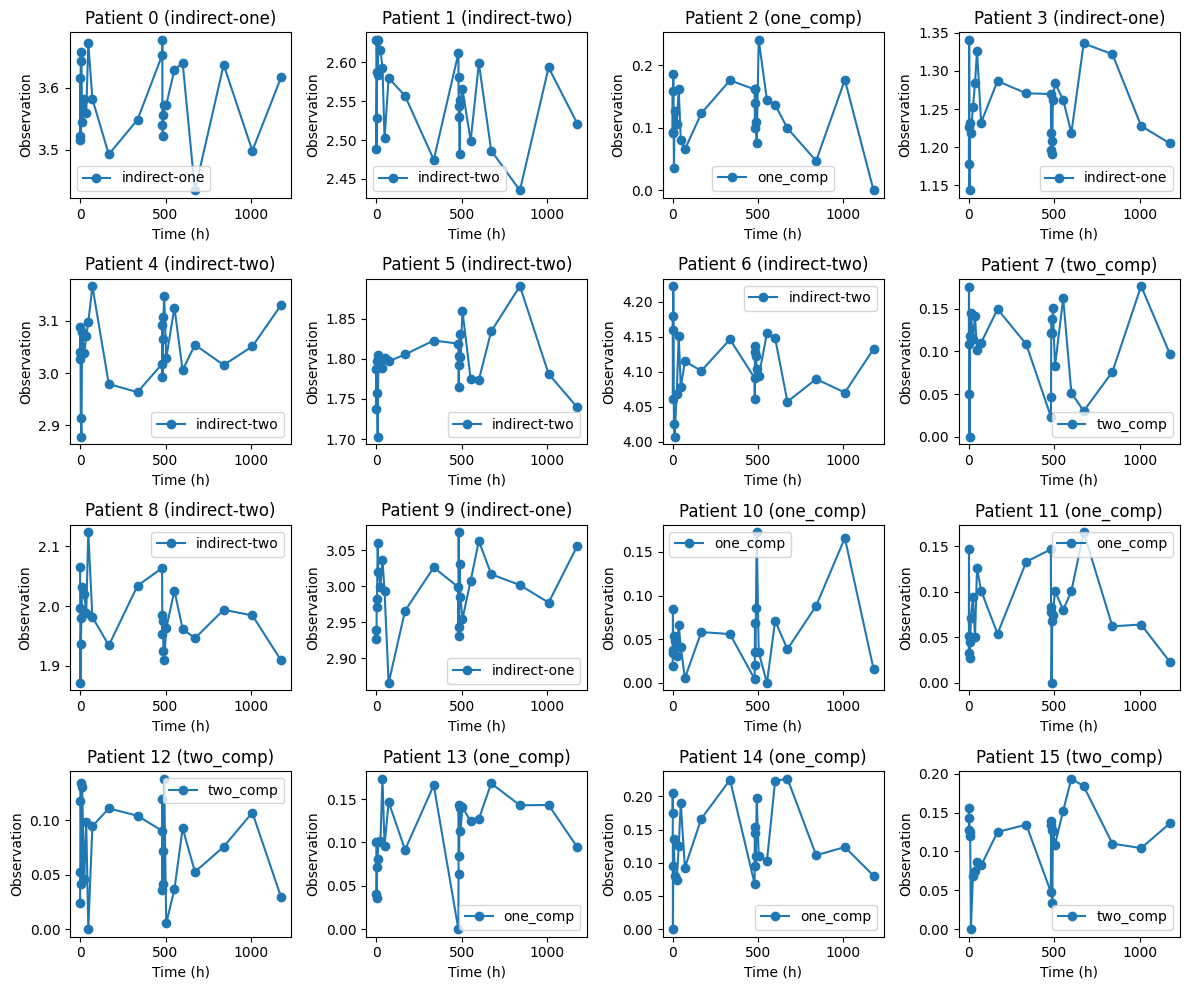

In [4]:
# -----------------------------
# EXAMPLE USAGE
# -----------------------------
np.random.seed(123)
synthetic_data = []
# we create dataset for the two models that gives biomarker levels
for i in range(1, 16):
   synthetic_data.extend(generate_synthetic_dataset(N=500, model_classes = ["one_comp", "two_comp", "indirect-one", "indirect-two"], dose=i, times=pkpd_times_np))
# Plot
fig, axes = plt.subplots(4, 4, figsize=(12,10))
axes = axes.flatten()
for i, patient in enumerate(synthetic_data[:16]):
    ax = axes[i]
    if patient["model"] in ["one_comp", "two_comp"]:
        ax.plot(patient["times"], patient["concentration"], 'o-', label=patient["model"])
    else:
        ax.plot(patient["times"], patient["response"], 'o-', label=patient["model"])
    ax.set_title(f"Patient {patient['id']} ({patient['model']})")
    ax.set_xlabel("Time (h)")
    ax.set_ylabel("Observation")
    ax.legend()
plt.tight_layout()
plt.show()

In [5]:
# creating numpy dataset from synthetic data for training
X_np = np.zeros((len(synthetic_data),25))
y_class_np = np.zeros((len(synthetic_data)))
y_reg_np = np.zeros((len(synthetic_data),9))

def parameter_vector_creator(parameter_dict):
  keys = ["ka", "CL", "V", "Vc", "Vp", "Q", "kin", "kout", "IC50"]
  result = []
  for key in keys:
    item = parameter_dict.get(key)
    if item==None:
      result.append(0)
    else:
      result.append(item)

  return np.array(result)

for i in range(len(synthetic_data)):
  entry = synthetic_data[i]
  if entry['model']=='one_comp':
    X_np[i] = entry['concentration']
    y_class_np[i] = 0
    y_reg_np[i] = parameter_vector_creator(entry['params'])
  elif entry['model']=='two_comp':
    X_np[i] = entry['concentration']
    y_class_np[i] = 1
    y_reg_np[i] = parameter_vector_creator(entry['params'])
  elif entry['model']=='indirect-one':
    X_np[i] = entry['response']
    y_class_np[i] = 2
    y_reg_np[i] = parameter_vector_creator(entry['params'])
  elif entry['model']=='indirect-two':
    X_np[i] = entry['response']
    y_class_np[i] = 3
    y_reg_np[i] = parameter_vector_creator(entry['params'])


In [6]:
X_np = np.expand_dims(X_np, axis=2)

In [7]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

class MultiLabelTensorDataset(Dataset):
    def __init__(self, X_np, y_class_np, y_reg_np):
        self.X = torch.tensor(X_np, dtype=torch.float32)
        self.y_class = torch.tensor(y_class_np, dtype=torch.long)             # shape: (N,)
        self.y_reg = torch.tensor(y_reg_np, dtype=torch.float32)              # shape: (N, reg_dim)

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx], self.y_class[idx], self.y_reg[idx]


# Build the Dataset
synthetic_dataset = MultiLabelTensorDataset(X_np, y_class_np, y_reg_np)

# Example usage:
x, y_class, y_reg = synthetic_dataset[0]
print("x:", x.shape)
print("y_class:", y_class.shape)
print("y_reg:", y_reg.shape)


x: torch.Size([25, 1])
y_class: torch.Size([])
y_reg: torch.Size([9])


In [8]:
# use DataLoader to train using batches
synthetic_dataloader = DataLoader(synthetic_dataset, batch_size=16, shuffle=True)
batch = next(iter(synthetic_dataloader))
x, y_class, y_reg = batch
print(x.shape)
print(y_class.shape)
print(y_reg.shape)

torch.Size([16, 25, 1])
torch.Size([16])
torch.Size([16, 9])


In [9]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=100, dropout=0.1):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) *
                             -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1), :]
        return self.dropout(x)

# this model inputs a sequential data and gets a fixed vector representation
# using that vector it uses two separate networks
# one that predicts the model
# another that predicts the parameter values
class TransformerEncoderModel(nn.Module):
    def __init__(self, input_dim, d_model, nhead, num_layers, hidden_dim, num_models, max_num_params, dim_feedforward=128, dropout=0.1, max_len=100):
        super().__init__()
        self.input_linear = nn.Linear(input_dim, d_model)
        self.pos_encoder = PositionalEncoding(d_model, max_len, dropout)
        encoder_layer = nn.TransformerEncoderLayer(d_model, nhead, dim_feedforward, dropout, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers)
        self.d_model = d_model
        # using the encoded vector we make predictions about the model and the parameter vector

        self.model_predictor = nn.Sequential(
                nn.Linear(d_model, hidden_dim),
                nn.ReLU(),
                nn.Linear(hidden_dim, num_models),
        )
        self.parameter_predictor = nn.Sequential(
                nn.Linear(d_model, hidden_dim),
                nn.ReLU(),
                nn.Linear(hidden_dim, max_num_params),
        )


    def forward(self, src, src_key_padding_mask=None):
        src = self.input_linear(src) * math.sqrt(self.d_model)
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src, src_key_padding_mask=src_key_padding_mask)
        # only take first vector of the output [:,0,:]
        model_class = self.model_predictor(output[:,0,:])
        parameter_vector = self.parameter_predictor(output[:,0,:])
        return model_class, parameter_vector

# Example: collate a batch of variable length sequences
def collate_batch(batch, pad_value=0):
    # batch: list of (tensor, target) pairs
    xs, ys = zip(*batch)
    lengths = [x.shape[0] for x in xs]
    max_len = max(lengths)
    # Pad sequences
    xs_padded = [torch.nn.functional.pad(x, (0,0,0,max_len-x.shape[0]), value=pad_value) for x in xs]
    xs_padded = torch.stack(xs_padded) # (batch_size, max_len, input_dim)
    # Create src_key_padding_mask: True for PAD, False for valid
    mask = torch.zeros((len(xs), max_len), dtype=torch.bool)
    for i, l in enumerate(lengths):
        if l < max_len:
            mask[i, l:] = True
    ys_padded = [torch.nn.functional.pad(y, (0,max_len-y.shape[0]), value=pad_value) for y in ys]
    ys_padded = torch.stack(ys_padded)
    return xs_padded, ys_padded, mask


In [10]:
# currently the input dimension is 1, but if we include data such as dose AMT as the sequential input data we can extend it further
model = TransformerEncoderModel(input_dim=1, d_model=32, nhead=4, num_layers=6, hidden_dim=64, num_models=4, max_num_params=9, dim_feedforward=128, dropout=0.1, max_len=100)

In [11]:
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import random_split

def train(model, dataset, batch_size, lr, gamma, num_epochs):
  # we use two losses
  # first loss is the categorical loss for the model classification
  # second loss is the MSELoss for the parameter space
  # Iterating over the dataloader yields batches:
  train_size = int(0.9 * len(dataset))
  valid_size = len(dataset) - train_size

  # Randomly split dataset
  train_dataset, valid_dataset = random_split(dataset, [train_size, valid_size])

  # Create DataLoaders
  train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
  valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

  batch = next(iter(train_loader))
  batch_x, batch_y_class, batch_y_reg = batch

  optimizer = optim.Adam(model.parameters(), lr=lr)
  scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=gamma)  # LR decays every 10 epochs
  criterion_class = nn.CrossEntropyLoss()
  criterion_reg = nn.MSELoss()

  train_losses = []
  valid_losses = []
  for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    for batch_x, batch_y_class, batch_y_reg in train_loader:
      optimizer.zero_grad()
      outputs_class, outputs_reg = model(batch_x)
      loss_cls = criterion_class(outputs_class, batch_y_class)
      loss_reg = criterion_reg(outputs_reg, batch_y_reg)
      loss = loss_cls + loss_reg
      loss.backward()
      optimizer.step()
      total_loss += loss.item() * batch_x.size(0)
    scheduler.step()  # update LR after each epoch
    with torch.no_grad():
      vbatch_x, vbatch_y_class, vbatch_y_reg = next(iter(valid_loader))
      voutputs_class, voutputs_reg = model(vbatch_x)
      vloss_cls = criterion_class(voutputs_class, vbatch_y_class)
      vloss_reg = criterion_reg(voutputs_reg, vbatch_y_reg)
      vloss = vloss_cls + vloss_reg

    avg_loss = total_loss / len(train_dataset)
    current_lr = scheduler.get_last_lr()[0]
    print(f"Epoch {epoch+1}/{num_epochs}, Average Loss: {avg_loss:.4f}, LR: {current_lr:.6f}")
    train_losses.append(avg_loss)
    valid_losses.append(vloss.item())

  return train_losses, valid_losses

In [12]:
# separate dataset further into train, test data
train_n = int(X_np.shape[0]*0.9)

train_dataset = MultiLabelTensorDataset(X_np[:train_n], y_class_np[:train_n], y_reg_np[:train_n])
test_dataset = MultiLabelTensorDataset(X_np[train_n:], y_class_np[train_n:], y_reg_np[train_n:])

print(len(train_dataset))
print(len(test_dataset))

6750
750


In [13]:
# define and train model
model = TransformerEncoderModel(input_dim=1, d_model=32, nhead=4, num_layers=6, hidden_dim=64, num_models=4, max_num_params=9, dim_feedforward=128, dropout=0.1, max_len=100)
train_loss, valid_loss = train(model, train_dataset, batch_size=16, lr=2e-4, gamma=0.99, num_epochs=100)

Epoch 1/100, Average Loss: 171.4278, LR: 0.000200
Epoch 2/100, Average Loss: 109.8300, LR: 0.000200
Epoch 3/100, Average Loss: 90.5590, LR: 0.000200
Epoch 4/100, Average Loss: 79.1063, LR: 0.000200
Epoch 5/100, Average Loss: 76.9354, LR: 0.000200
Epoch 6/100, Average Loss: 76.0469, LR: 0.000200
Epoch 7/100, Average Loss: 76.7157, LR: 0.000200
Epoch 8/100, Average Loss: 76.0597, LR: 0.000200
Epoch 9/100, Average Loss: 75.6238, LR: 0.000200
Epoch 10/100, Average Loss: 75.4041, LR: 0.000198
Epoch 11/100, Average Loss: 74.9758, LR: 0.000198
Epoch 12/100, Average Loss: 75.2273, LR: 0.000198
Epoch 13/100, Average Loss: 74.8325, LR: 0.000198
Epoch 14/100, Average Loss: 75.1816, LR: 0.000198
Epoch 15/100, Average Loss: 75.2313, LR: 0.000198
Epoch 16/100, Average Loss: 74.7528, LR: 0.000198
Epoch 17/100, Average Loss: 74.8441, LR: 0.000198
Epoch 18/100, Average Loss: 74.7401, LR: 0.000198
Epoch 19/100, Average Loss: 74.6057, LR: 0.000198
Epoch 20/100, Average Loss: 74.5320, LR: 0.000196
Epoch 2

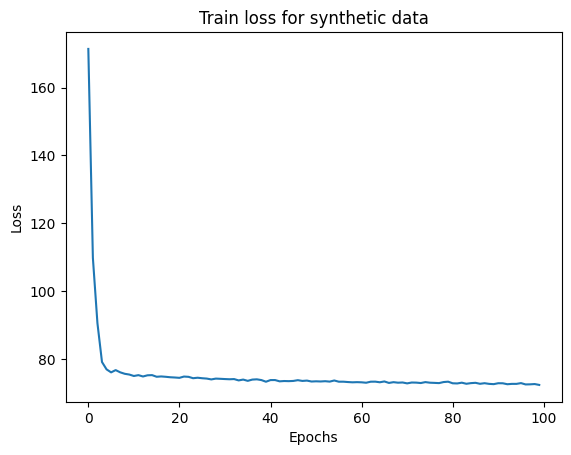

In [31]:
plt.plot(train_loss)
plt.title("Train loss for synthetic data")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.savefig("Train_loss_Stage1.png")

Text(0, 0.5, 'Loss')

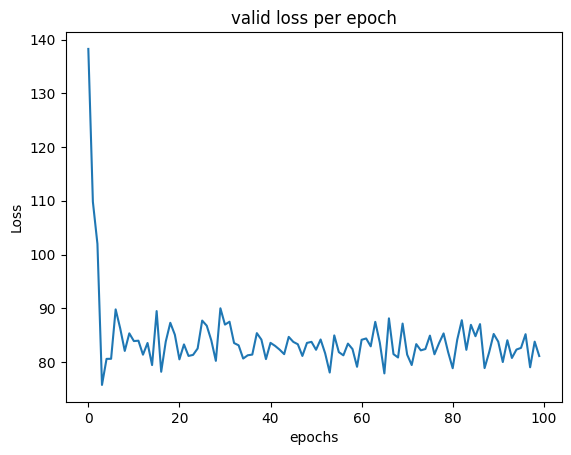

In [15]:
plt.plot(valid_loss)
plt.title("valid loss per epoch")
plt.xlabel("epochs")
plt.ylabel("Loss")

In [16]:
# test using test dataset
total_correct = 0
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)
for batch_x, batch_y_class, batch_y_reg in test_loader:
  outputs_class, outputs_reg = model(batch_x)
  pred_classes = torch.argmax(outputs_class, dim=1)
  correct = (pred_classes == batch_y_class).sum().item()
  total_correct+=correct

model_classification_accuracy = total_correct/len(test_dataset)
print("accuracy of model: ", model_classification_accuracy*100, "%")

accuracy of model:  79.46666666666667 %


In [17]:
# obtain the time series of our dataset
from google.colab import drive
import pandas as pd

drive.mount('/content/drive/')
df = pd.read_csv('/content/drive/MyDrive/QIC/QIC2025-EstDat.csv')
column_arrays = []
for key in df.keys():
  column_arrays.append(df[key].to_numpy())

individuals = []

for i in range(48):
  individuals.append([])

for i in range(len(column_arrays[0])):
  individuals[column_arrays[0][i]-1].append(np.array([column_arrays[1][i],column_arrays[2][i],column_arrays[3][i],column_arrays[4][i],column_arrays[5][i],column_arrays[6][i],column_arrays[7][i],column_arrays[8][i],column_arrays[9][i],column_arrays[10][i]]))

individual_data = []
for individual in individuals:
  individual_data.append(np.vstack(individual))

individual_data_wo_mdv = []

for i in range(len(individual_data)):
  before = individual_data[i]
  after = []
  for j in range(len(before)):
    if before[j][6]==1:
      pass
    else:
      after.append(np.concat([before[j][:6],before[j][7:]]))
  individual_data_wo_mdv.append(np.vstack(after))


individual_data_wo_mdv_biomarker = []

for i in range(len(individual_data_wo_mdv)):
  before = individual_data_wo_mdv[i]
  after_b = []
  for j in range(len(before)):
    if before[j][-1]==2:
      after_b.append(before[j][:8])
    else:
      pass
  if after_b != []:
    individual_data_wo_mdv_biomarker.append(np.vstack(after_b))

dosed_time_series_bio = np.zeros((36,25))
for i in range(12,48):
  dosed_time_series_bio[i-12] = individual_data_wo_mdv_biomarker[i][:, 4]

Mounted at /content/drive/


In [18]:
dosed_time_series_bio = np.expand_dims(dosed_time_series_bio, axis=2)
dosed_time_series_bio_tensor = torch.tensor(dosed_time_series_bio, dtype=torch.float32)

In [19]:
# use it to predict the model classes and parameter values
bio_class_output, bio_param_output = model(dosed_time_series_bio_tensor)

In [20]:
def result_printer(class_result, param_result, result_file):
  # each are size (batch, num_class) and (batch, num_param)
  class_index = torch.argmax(class_result, dim=1)
  class_stats = np.zeros(4)
  for i in range(param_result.shape[0]):
    if class_index[i]==0:
      print("class: one_comp, params: ka: ", param_result[i][0].item(), "CL: ", param_result[i][1].item(), "V: ", param_result[i][2].item())
      with open(result_file, "a") as f:
        print("class: one_comp, params: ka: ", param_result[i][0].item(), "CL: ", param_result[i][1].item(), "V: ", param_result[i][2].item(), file=f)
      class_stats[0]+=1
    elif class_index[i]==1:
      print("class: two_comp, params: CL: ", param_result[i][1].item(), "Vc: ", param_result[i][3].item(), "Vp: ", param_result[i][4].item(), "Q: ", param_result[i][5].item())
      with open(result_file, "a") as f:
        print("class: two_comp, params: CL: ", param_result[i][1].item(), "Vc: ", param_result[i][3].item(), "Vp: ", param_result[i][4].item(), "Q: ", param_result[i][5].item(), file=f)
      class_stats[1]+=1
    elif class_index[i]==2:
      print("class: indirect-one, params: ka: ", param_result[i][0].item(), "CL: ", param_result[i][1].item(), "V: ", param_result[i][2].item(), "kin: ",param_result[i][6].item(), "kout: ", param_result[i][7].item(), "IC50", param_result[i][8].item())
      with open(result_file, "a") as f:
        print("class: indirect-one, params: ka: ", param_result[i][0].item(), "CL: ", param_result[i][1].item(), "V: ", param_result[i][2].item(), "kin: ",param_result[i][6].item(), "kout: ", param_result[i][7].item(), "IC50", param_result[i][8].item(),file=f)
      class_stats[2]+=1
    elif class_index[i]==3:
      print("class: indirect-two, params: CL: ", param_result[i][1].item(), "Vc: ", param_result[i][3].item(), "Vp: ", param_result[i][4].item(), "Q: ", param_result[i][5].item(), "kin: ", param_result[i][6].item(), "kout: ", param_result[i][7].item(), "IC50: ", param_result[i][8].item())
      with open(result_file, "a") as f:
        print("class: indirect-two, params: CL: ", param_result[i][1].item(), "Vc: ", param_result[i][3].item(), "Vp: ", param_result[i][4].item(), "Q: ", param_result[i][5].item(), "kin: ", param_result[i][6].item(), "kout: ", param_result[i][7].item(), "IC50: ", param_result[i][8].item(),file=f)
      class_stats[3]+=1
  print(class_stats)

In [21]:
result_printer(bio_class_output, bio_param_output, "parameter_range.txt")

class: indirect-two, params: CL:  11.60762882232666 Vc:  10.569707870483398 Vp:  20.435745239257812 Q:  3.2087607383728027 kin:  1.0460344552993774 kout:  0.536500096321106 IC50:  2.908116340637207
class: indirect-one, params: ka:  0.6694733500480652 CL:  11.492448806762695 V:  15.229692459106445 kin:  1.0584745407104492 kout:  0.5360344648361206 IC50 2.9407365322113037
class: indirect-one, params: ka:  0.6046356558799744 CL:  11.169039726257324 V:  15.04204273223877 kin:  1.0993547439575195 kout:  0.5266629457473755 IC50 2.93457293510437
class: indirect-one, params: ka:  0.6364928483963013 CL:  11.336714744567871 V:  14.904606819152832 kin:  1.0820176601409912 kout:  0.5301398038864136 IC50 2.960944890975952
class: indirect-one, params: ka:  0.6463127732276917 CL:  11.353585243225098 V:  14.681379318237305 kin:  1.0733184814453125 kout:  0.5265971422195435 IC50 3.010256290435791
class: indirect-one, params: ka:  0.6366182565689087 CL:  11.114487648010254 V:  13.80033016204834 kin:  1.

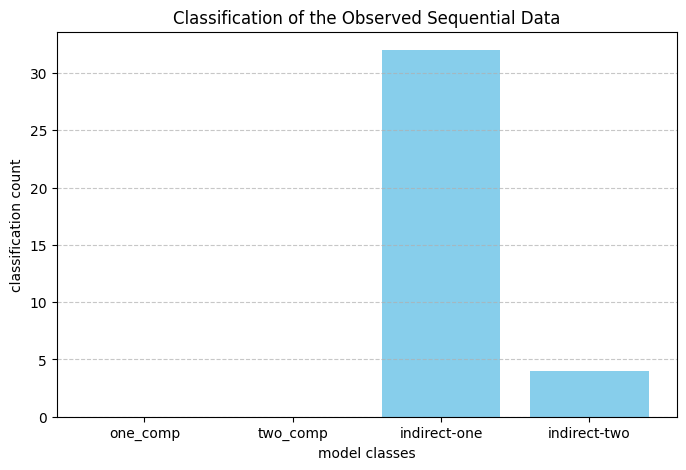

In [23]:
categories = ['one_comp', 'two_comp', 'indirect-one', 'indirect-two']
model_stats = [ 0,  0, 32, 4]

plt.figure(figsize=(8, 5))
plt.bar(categories, model_stats, color='skyblue')
plt.xlabel('model classes')
plt.ylabel('classification count')
plt.title('Classification of the Observed Sequential Data')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig("Classified_Model_Class")

In [26]:
f = open("parameter_range_new.txt", "r")
lines = f.readlines()

ka = [] #3
CL = [] #6
V = [] #9
kin = [] #12
kout = [] #15
IC50 = [] #17

for line in lines:
  if "class: indirect-one" in line:
    split_line = line.split(",")[-1].split("params:")[-1].split(" ")
    ka.append(np.float32(split_line[3]))
    CL.append(np.float32(split_line[6]))
    V.append(np.float32(split_line[9]))
    kin.append(np.float32(split_line[12]))
    kout.append(np.float32(split_line[15]))
    IC50.append(np.float32(split_line[17]))


In [27]:
ka = np.array(ka).reshape(32,1)
CL = np.array(CL).reshape(32,1)
V = np.array(V).reshape(32,1)
kin = np.array(kin).reshape(32,1)
kout = np.array(kout).reshape(32,1)
IC50 = np.array(IC50).reshape(32,1)

In [28]:
data1 = np.hstack((ka, kin, kout))
data2 = np.hstack((CL, V))
data3 = np.hstack((IC50))

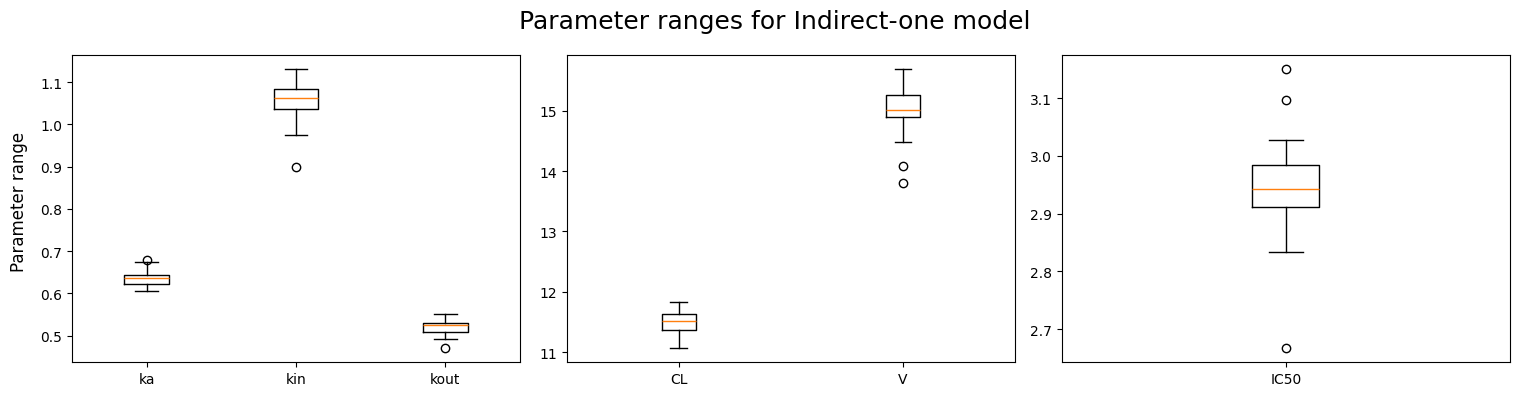

In [29]:
fig, axs = plt.subplots(1, 3, figsize=(15, 4))  # 1 row, 3 columns


axs[0].boxplot(data1, tick_labels=["ka", "kin", "kout"])
axs[1].boxplot(data2, tick_labels=["CL", "V"])
axs[2].boxplot(data3, tick_labels=["IC50"])

fig.suptitle("Parameter ranges for Indirect-one model", fontsize=18)
fig.text(-0.01, 0.5, 'Parameter range', va='center', rotation='vertical', fontsize=12)
plt.tight_layout()  # Adjust spacing to prevent overlap
plt.savefig("Determined_Parameter_Range_Stage1")

In [30]:
# further improvement to the model
# add more model classes
# make the dose AMT a time dependent variable so that it can be input with the sequential DV into our TransformerEncoder model for better training and prediction
# more hyperparameter tuning for the training